In [1]:
# Imports
import pandas as pd
import numpy as np
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# Sklearn libraries.
from sklearn import datasets, linear_model, ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
import string

from collections import Counter
#deep learning library

import json, os, re, shutil, sys, time
import collections, itertools
import unittest
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz




### 1. Load Data

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
# Unzip gz file.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

# Load JSON into dataframe.
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


In [4]:
start = time.time()
df = getDF('/home/legu/data/reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
end = time.time()
print "Time Used %fs" %(end - start)

Time Used 43.630344s


### 2. Data Exploration

In [5]:
print df.columns

print df['reviewText'][0]

df.head(5)

Index([u'reviewerID', u'asin', u'reviewerName', u'helpful', u'unixReviewTime',
       u'reviewText', u'overall', u'reviewTime', u'summary'],
      dtype='object')
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",1297468800,This is a great tutu and at a really great pri...,5.0000,"02 12, 2011",Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",1358553600,I bought this for my 4 yr old daughter for dan...,5.0000,"01 19, 2013",Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",1357257600,What can I say... my daughters have it in oran...,5.0000,"01 4, 2013",I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]",1398556800,"We bought several tutus at once, and they are ...",5.0000,"04 27, 2014","Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",1394841600,Thank you Halo Heaven great product for Little...,5.0000,"03 15, 2014",Grammy's Angels Love it


#### Exploring helpfulness scores.

In [6]:
helpfulness = []
total_votes = []
for i in df['helpful']:
    if i[1] == 0:
        helpfulness.append(np.nan)
        total_votes.append(np.nan)
    else:
        helpfulness.append(float(i[0])/i[1])
        total_votes.append(i[1])
        
# Convert to numpy array.
helpfulness = np.array(helpfulness)
total_votes = np.array(total_votes)

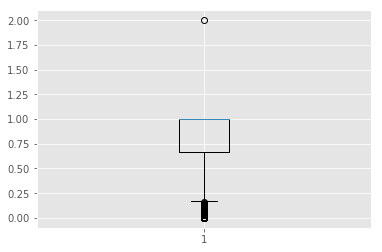

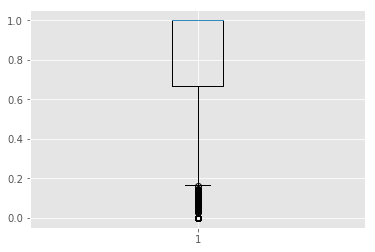

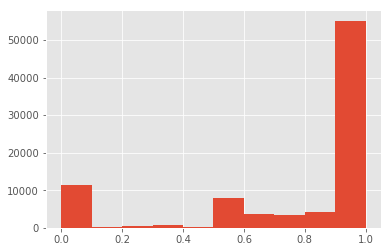

In [7]:
# Plot boxplot.
nonnan_helpfulness = helpfulness[~np.isnan(helpfulness)]

plt.figure()
plt.boxplot(nonnan_helpfulness)

# Remove invalid record.
helpfulness_clean = nonnan_helpfulness[np.where(nonnan_helpfulness < 2)]

plt.figure()
plt.boxplot(helpfulness_clean[~np.isnan(helpfulness_clean)])

# Plot histogram
plt.figure()
plt.hist(helpfulness_clean)

plt.show()

#### Exploring review text lengths.

In [11]:
# Compute review lengths.
review_lengths = np.array([len(x) for x in df['reviewText']])
print review_lengths
print "average review length: %i" %np.mean(review_lengths)
print "min review length: %i" %np.min(review_lengths)
print "max review length: %i" %np.max(review_lengths)

[ 172  306  312 ...,  914 1126 1295]
average review length: 315
min review length: 0
max review length: 22646


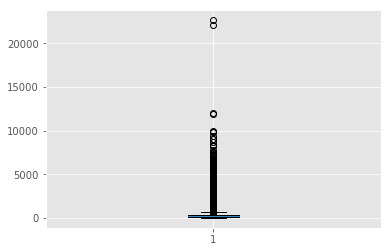

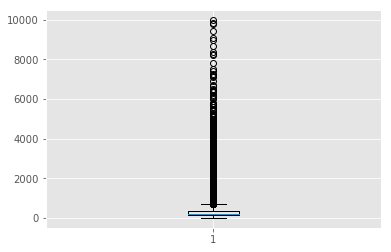

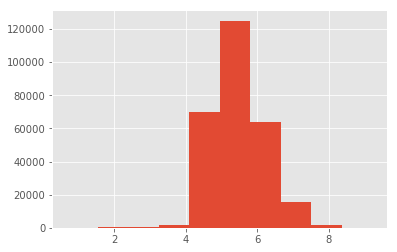

In [12]:
# Plot boxplot.
plt.figure()
plt.boxplot(review_lengths)

# Remove outliers.
review_lengths_minus_outliers = review_lengths[np.where(np.logical_and(review_lengths > 0, review_lengths < 10000))]

# Plot boxplot.
plt.figure()
plt.boxplot(review_lengths_minus_outliers)

# # Plot histogram using log(review length) due to right skewed distribution.
plt.figure()
plt.hist(np.log(review_lengths_minus_outliers))

plt.show()

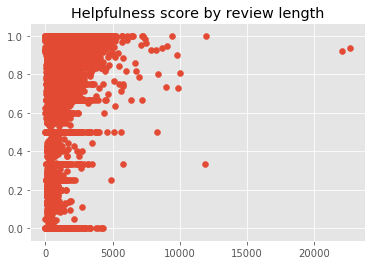

In [13]:
# Remove invalid and nan values.
helpfulness_clean = np.delete(helpfulness, 30730)
review_lengths_clean = np.delete(review_lengths, 30730)
nonnan_helpfulness_clean = helpfulness_clean[~np.isnan(helpfulness_clean)]
nonnan_review_lengths_clean = review_lengths_clean[~np.isnan(helpfulness_clean)]

# Print scatterplot of review length to helpfulness score.
plt.figure()
plt.scatter(nonnan_review_lengths_clean, nonnan_helpfulness_clean)
plt.title("Helpfulness score by review length")
plt.show()

In [14]:
# Compute correlation.
np.corrcoef(nonnan_review_lengths_clean, nonnan_helpfulness_clean)[1,0]

0.054565284474689578

#### Exploring review scores.

In [19]:
# Compute scores.
review_scores = np.array(df['overall'])
print "average review score: %i" %np.mean(review_scores)
print "min review score: %i" %np.min(review_scores)
print "max review score: %i" %np.max(review_scores)

average review score: 4
min review score: 1
max review score: 5


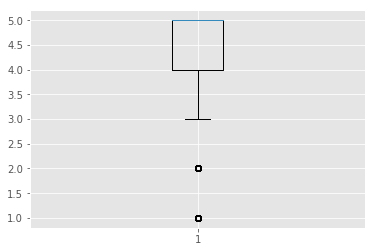

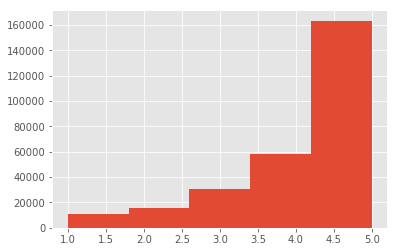

In [20]:
# Plot boxplot.
plt.figure()
plt.boxplot(review_scores)

# # Plot histogram.
plt.figure()
plt.hist(review_scores, bins=5)

plt.show()

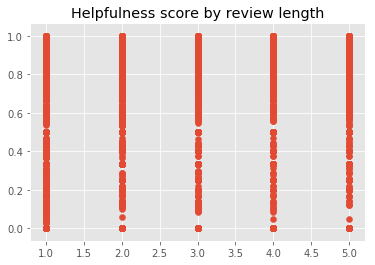

In [21]:
# Remove invalid and nan values.
review_scores_clean = np.delete(review_scores, 30730)
nonnan_review_scores_clean = review_scores_clean[~np.isnan(helpfulness_clean)]

# Print scatterplot of review length to helpfulness score.
plt.figure()
plt.scatter(nonnan_review_scores_clean, nonnan_helpfulness_clean)
plt.title("Helpfulness score by review length")
plt.show()

In [22]:
# Compute correlation.
np.corrcoef(nonnan_review_scores_clean, nonnan_helpfulness_clean)[1,0]

0.18085804717359091

### 3. Build Baseline Model

In [8]:
#extract the review text
doc = np.array(df['reviewText'])

# Filter down to reviews with helpfulness scores.
# Remove item with invalid helpfulness score.
doc_clean = np.delete(doc, 30730)
nonnan_doc_clean = doc_clean[~np.isnan(helpfulness_clean)]

/home/legu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 278676 but corresponding boolean dimension is 87020


### 4. Deep Learning Exploration

#### Build LSTM Model

#### 1.Split the dataset into traing and test 

In [16]:
len(nonnan_doc_clean )
msk = np.random.rand(nonnan_doc_clean.shape[0]) <= 0.7

X_train = nonnan_doc_clean[msk]
X_test = nonnan_doc_clean[~msk]
y_train = y[msk]
y_test = y[~msk]
X_sample = nonnan_doc_clean[0:100]
y_sample = y[0:100]

#### 2.Convert the word into index

In [199]:
def get_tokens(docs):
    tokens =[]
    for i in docs:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        tokens.extend(token)
    return tokens

tokens = get_tokens(X_sample)

In [200]:
def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [28]:
dic, rev_dict = build_dataset(tokens)

In [35]:
dic['limited']

712

In [36]:
rev_dict[712]

'limited'

In [49]:
X_sample_ids = []
for i in X_sample:
    lowers = i.lower()
    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    token = nltk.word_tokenize(no_punctuation)
    j=[dic[w] for w in token]
    X_sample_ids.append(j)
    

##For valiadtion, X_sample_ids[0]
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++
[9, 6, 4, 55, 205, 3, 37, 4, 54, 55, 60, 5, 207, 515, 402, 37, 57, 72, 23, 884, 1, 533, 17, 233, 3, 151, 396, 52, 1542, 205, 13, 343, 99, 1056, 4]

In [53]:
print X_sample_ids[0]
print y_sample[0]

[9, 6, 4, 55, 205, 3, 37, 4, 54, 55, 60, 5, 207, 515, 402, 37, 57, 72, 23, 884, 1, 533, 17, 233, 3, 151, 396, 52, 1542, 205, 13, 343, 99, 1056, 4]
[ 0.875]


#### 3.build tensor flow model - training

In [ ]:
##define variables 
n_hidden = 10 
with tf.variable_scope("softmax"):
    W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
    b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")

with tf.variable_scope("recurrent"):
    rnn_cell = rnn.BasicLSTMCell(n_hidden)
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    initial_h_ = self.cell_.zero_state(self.batch_size_,dtype=tf.float32)
    outputs, self.final_h_ = tf.nn.dynamic_rnn(self.cell_, inputs=self.x_,initial_state=self.initial_h_, sequence_length=100)



In [196]:
def MakeFancyRNNCell(H, keep_prob, num_layers=1):
    """Make a fancy RNN cell.

    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.

    Args:
      H: hidden state size
      keep_prob: dropout keep prob (same for input and output)
      num_layers: number of cell layers

    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    cells = []
    for _ in xrange(num_layers):
        cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
        cell = tf.contrib.rnn.DropoutWrapper(
        cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
        cells.append(cell)
    return tf.contrib.rnn.MultiRNNCell(cells)


In [197]:
##have to fix here!!!
def RNN(x):
    n_hidden = 10 
    with tf.variable_scope("softmax"):
        W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
        b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")
    # reshape to [1, n_input]
    n_input = len(x)
    x = tf.reshape(x, [-1, n_input])

    # Generate a n_input-element sequence of inputs
    # (eg. [had] [a] [general] -> [20] [6] [33])
    x = tf.split(x,n_input,1)
#     print x
    # 1-layer LSTM with n_hidden units.
    with tf.variable_scope('cell_def'):
        lstm_cell = MakeFancyRNNCell(H=n_hidden,keep_prob=1)
#         lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=0.0)
#     print x
    # generate prediction
#     outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.int32)
#     initial_h_ = lstm_cell.zero_state(1,dtype=tf.int32)
#     with tf.variable_scope('rnn_def',reuse=True):
#         outputs,final_h_ = lstm_cell(x,dtype=tf.int32)
    outputs,final_h_ = tf.contrib.rnn.static_rnn(lstm_cell, x,dtype=tf.int32)
            
            

    # there are n_input outputs but
    # we only want the last output
    return tf.matmul(outputs[-1], W_out_) + b_out_

In [198]:
import tensorflow as tf
from tensorflow.contrib import rnn


learning_rate =0.1
pred = RNN(X_sample_ids[0])

# Loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_sample[0]))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

ValueError: Variable rnn/multi_rnn_cell/cell_0/basic_lstm_cell/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 1044, in _linear
    _WEIGHTS_VARIABLE_NAME, [total_arg_size, output_size], dtype=dtype)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 241, in __call__
    concat = _linear([inputs, h], 4 * self._num_units, True)
  File "/home/legu/anaconda2/lib/python2.7/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 713, in __call__
    output, new_state = self._cell(inputs, state, scope)


In [ ]:
_, loss, onehot_pred = session.run([optimizer, cost, pred], 
                                        feed_dict={x: symbols_in_keys, y: symbols_out_onehot})

### Scratch below

In [17]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(60843,)
(26177,)
(60843, 1)
(26177, 1)


In [18]:
X_sample = nonnan_doc_clean[0:100]
y_sample = y[0:100]

In [19]:
print len(X_sample[0].split())
print X_sample[0]
print y[0]

35
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++
[ 0.875]


In [22]:
len(nltk.corpus.__getattr__('brown').words())

1161192

In [86]:
corpus = X_sample[0].split()
bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)

In [87]:
for i, (w,y) in enumerate(bi):
    print w
    print y_sample[0]

[['For' 'what' 'I' 'paid' 'for' 'two' 'tutus' 'is' 'unbeatable' 'anywhere!'
  'I' 'ordered' 'a' 'pink' 'and' 'turquios' 'and' 'they' 'are' 'vibrant'
  'and' 'beautiful!' 'The' 'tutu' 'is' 'very' 'full!' 'Princess' 'style!'
  'Not' 'cheaply' 'made!' 'Not' 'cheap' 'materia!' 'Obviously' 'someone'
  'made' 'these' 'with' 'love' 'and' 'care!' 'I' 'paid' 'less' 'than' '7'
  'bucks' 'for' 'a' 'tutu' 'I' 'and' 'I' 'feel' 'proud' 'of' 'my' 'self'
  'for' 'researching' 'to' 'the' 'point' 'of' 'finding' 'gold!Recommend'
  '2-6' 'years!My' 'daughter' 'is' 'two' '!' 'Wears' 'size' '4t' 'and'
  'this' 'skirt' '(' 'one' 'size' ')' 'fit' 'perfect' 'and' 'will'
  'probaly' 'be' 'able' 'to' 'accommodate' 'her' 'quickly' 'growing'
  'waist' 'for' 'some']]
[ 0.875]


In [99]:
import rnnlm
# import rnnlm_test
reload(rnnlm)
# reload(rnnlm_test)

<module 'rnnlm' from 'rnnlm.py'>

In [92]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0

    if train:
        train_op = lm.train_step_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        # At first batch in epoch, get a clean intitial state.
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})

        #### YOUR CODE HERE ####
        
        feed_dict = {lm.input_w_:w,
                 lm.target_y_:y,
                 lm.learning_rate_:learning_rate,
                 lm.initial_h_ : h}
            
        cost, _, h = session.run([loss, train_op,lm.final_h_],
                       feed_dict=feed_dict)
        
        
            
            
        #### END(YOUR CODE) ####
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print "[batch %d]: seen %d words at %d wps, loss = %.3f" % (
                i, total_words, avg_wps, avg_cost)
            tick_time = time.time()  # reset time ticker

    return total_cost / total_batches

In [93]:
V=1000
max_time = 20
batch_size = 50
learning_rate = 0.5
num_epochs = 5

# Model parameters
model_params = dict(V=100, 
                    H=100, 
                    softmax_ns=200,
                    num_layers=1)

# TF_SAVEDIR = "tf_saved"
# checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
# trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [101]:
# Will print status every this many seconds
import rnnlm
# import rnnlm_test
reload(rnnlm)
print_interval = 5

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
# shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
# if not os.path.isdir(TF_SAVEDIR):
#     os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)

    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
#         bi = utils.batch_generator(train_ids, batch_size, max_time)
        corpus = X_sample[0].split()
        bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)
        for i, (w,y) in enumerate(bi):
            w1=w
            
        bi= (w1,y_sample[y])
        print "[epoch %d] Starting epoch %d" % (epoch, epoch)
        #### YOUR CODE HERE ####
        # Run a training epoch.
        cost = run_epoch(lm, session, bi, 
                     learning_rate=learning_rate, train=True, 
                     verbose=False, tick_s=3600)

        #### END(YOUR CODE) ####
        print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    
        ##
        # score_dataset will run a forward pass over the entire dataset
        # and report perplexity scores. This can be slow (around 1/2 to 
        # 1/4 as long as a full epoch), so you may want to comment it out
        # to speed up training on a slow machine. Be sure to run it at the 
        # end to evaluate your score.
        print ("[epoch %d]" % epoch),
        #score_dataset(lm, session, train_ids, name="Train set")
        print ("[epoch %d]" % epoch),
        score_dataset(lm, session, test_ids, name="Test set")
        print ""
    
    # Save final model
    saver.save(session, trained_filename)

ValueError: Dimension must be 2 but is 3 for 'recurrent/transpose' (op: 'Transpose') with input shapes: [?,100], [3].

## Scratch Below

In [ ]:
print 1

In [62]:
import nltk
nltk.download('brown')

corpus = nltk.corpus.brown

[nltk_data] Downloading package brown to /Users/legu/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [72]:
!pip install vocabulary

    100% |████████████████████████████████| 593kB 408kB/s 
    100% |████████████████████████████████| 61kB 1.9MB/s 
    100% |████████████████████████████████| 102kB 1.2MB/s 
  Running setup.py bdist_wheel for vocabulary ... - \ done
  Stored in directory: /Users/legu/Library/Caches/pip/wheels/36/6c/c0/92bb20f79402d055c3bce3e89d9f2cce5d6937bc2aadc0fb45
Successfully built vocabulary
  Found existing installation: requests 2.11.1
    Uninstalling requests-2.11.1:
      Successfully uninstalled requests-2.11.1
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
import utils
import vocabulary
# train_sents, test_sents = utils.get_train_test_sents(corpus, split=0.8, shuffle=True)
vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(corpus))
print "Train set vocabulary: %d words" % vocab.size

AttributeError: 'module' object has no attribute 'Vocabulary'